<a href="https://colab.research.google.com/github/joacop01/Analisis-tiempo-frecuencia/blob/main/sam2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/drive/1mpg7fQ-ovcVqurc4KxWMeMUIkQnnqpTH">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-4j0w_chz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-4j0w_chz
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=6e73db344670f809e9332ef0e6422ac5033120d56fc43b5f71f4804f757fca5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-qb6gjl1f/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-04-22 01:38:47--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.124, 108.157.254.1

In [4]:
!pip install mcsm_benchs

ERROR: Ignored the following versions that require a different python version: 0.1.0 Requires-Python <3.11,>=3.8; 0.1.1 Requires-Python <3.11,>=3.8; 0.1.2 Requires-Python <3.11,>=3.8
ERROR: Could not find a version that satisfies the requirement mcsm_benchs (from versions: none)
ERROR: No matching distribution found for mcsm_benchs


In [5]:
# Relevant modules
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import scipy.signal as sg
from scipy.fft import fft, ifft
from numpy import pi as pi

# SAM
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

def show_mask(mask, ax, random_color=False, color=None):
    """
    Muestra una máscara sobre un eje matplotlib.

    Args:
        mask (ndarray): Máscara binaria.
        ax (matplotlib.axes.Axes): Eje sobre el que dibujar la máscara.
        random_color (bool): Si es True, se elige un color aleatorio.
        color (list o ndarray): Color RGBA a usar. Si es None y random_color=False, se usa color azul por defecto.
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    elif color is None:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])  # azul por defecto

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)
    ax.imshow(mask_image)


In [7]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
import numpy as np
from numpy.fft import fft, ifft

# Función para obtener una ventana Gaussiana con el tamaño especificado
def get_gauss_window(Nfft, L, prec=1e-6):
    """
    Genera una ventana Gaussiana con un tamaño determinado.

    Args:
        Nfft (int): Número de puntos de la FFT.
        L (float): Parámetro de escala de la ventana Gaussiana.
        prec (float, opcional): Precisión de la ventana. Por defecto es 1e-6.

    Returns:
        g (ndarray): La ventana Gaussiana generada.
    """
    l = np.floor(np.sqrt(-Nfft * np.log(prec) / np.pi)) + 1
    N = 2 * l + 1
    t0 = l + 1
    tmt0 = np.arange(0, N) - t0
    g = np.exp(-(tmt0 / L) ** 2 * np.pi)
    g = g / np.linalg.norm(g)
    return g

# Función para obtener una ventana Gaussiana redonda para la STFT
def get_round_window(Nfft, prec=1e-6):
    """
    Genera una ventana Gaussiana redonda, es decir, con el mismo soporte esencial
    en tiempo y frecuencia, para el cálculo de la Transformada de Fourier de Corto Tiempo (STFT).

    Args:
        Nfft (int): Número de puntos de la FFT.
        prec (float, opcional): Precisión de la ventana. Por defecto es 1e-6.

    Returns:
        g (ndarray): La ventana Gaussiana generada.
        L (float): La escala de la ventana Gaussiana, calculada como L = sqrt(Nfft).
    """
    L = np.sqrt(Nfft)
    l = np.floor(np.sqrt(-Nfft * np.log(prec) / np.pi)) + 1

    N = 2 * l + 1
    t0 = l + 1
    tmt0 = np.arange(0, N) - t0
    g = np.exp(-(tmt0 / L) ** 2 * np.pi)
    g = g / np.linalg.norm(g)
    return g, L

# Función para calcular la STFT de una señal
def get_stft(x, window=None, t=None, Nfft=None):
    """
    Calcula la Transformada de Fourier de Tiempo Corto (STFT) de una señal.

    Args:
        x (ndarray): La señal de entrada.
        window (ndarray, opcional): La ventana para la STFT.
        t (ndarray, opcional): Los índices de tiempo.
        Nfft (int, opcional): Número de puntos para la FFT.

    Returns:
        tfr (ndarray): La STFT de la señal.
    """
    xrow = len(x)

    if t is None:
        t = np.arange(0, xrow)

    if Nfft is None:
        Nfft = 2 * xrow

    if window is None:
        window, _ = get_round_window(Nfft)

    tcol = len(t)
    hlength = np.floor(Nfft / 4)
    hlength = int(hlength + 1 - np.remainder(hlength, 2))

    hrow = len(window)

    assert np.remainder(hrow, 2) == 1

    Lh = (hrow - 1) // 2
    tfr = np.zeros((Nfft, tcol), dtype=complex)
    for icol in range(0, tcol):
        ti = t[icol]
        tau = np.arange(-np.min([np.round(Nfft / 2), Lh, ti]), np.min([np.round(Nfft / 2), Lh, xrow - ti])).astype(int)
        indices = np.remainder(Nfft + tau, Nfft).astype(int)
        tfr[indices, icol] = x[ti + tau] * np.conj(window[Lh + tau]) / np.linalg.norm(window[Lh + tau])

    tfr = fft(tfr, axis=0)
    return tfr

# Función para calcular la ISTFT (inversa de la STFT)
def get_istft(tfr, window=None, t=None):
    """
    Calcula la inversa de la STFT para obtener la señal original.

    Args:
        tfr (ndarray): La STFT de la señal.
        window (ndarray, opcional): La ventana utilizada.
        t (ndarray, opcional): Los índices de tiempo.

    Returns:
        x (ndarray): La señal reconstruida.
    """
    N, NbPoints = tfr.shape
    tcol = len(t)
    hrow = len(window)
    Lh = (hrow - 1) // 2
    window = window / np.linalg.norm(window)
    tfr = ifft(tfr, axis=0)

    x = np.zeros((tcol,), dtype=complex)
    for icol in range(0, tcol):
        valuestj = np.arange(np.max([1, icol - N / 2, icol - Lh]), np.min([tcol, icol + N / 2, icol + Lh])).astype(int)
        for tj in valuestj:
            tau = icol - tj
            indices = np.remainder(N + tau, N).astype(int)
            x[icol] = x[icol] + tfr[indices, tj] * window[Lh + tau]

        x[icol] = x[icol] / np.sum(np.abs(window[Lh + icol - valuestj]) ** 2)
    return x

# Función para calcular el espectrograma de una señal
def get_spectrogram(signal, window=None, Nfft=None, t=None, onesided=True):
    """
    Calcula el espectrograma de una señal utilizando una ventana dada.

    Args:
        signal (ndarray): La señal de entrada.
        window (ndarray, opcional): La ventana utilizada para la STFT.
        Nfft (int, opcional): Número de puntos de la FFT.
        t (ndarray, opcional): Los índices de tiempo.
        onesided (bool, opcional): Si es True, devuelve el espectrograma de un solo lado (frecuencias positivas).

    Returns:
        S (ndarray): El espectrograma de la señal.
        stft (ndarray): La STFT de la señal.
    """
    N = np.max(signal.shape)
    if Nfft is None:
        Nfft = 2 * N

    if window is None:
        window, _ = get_round_window(Nfft)

    if t is None:
        t = np.arange(0, N)

    stft = get_stft(signal, window=window, t=t, Nfft=Nfft)

    if onesided:
        S = np.abs(stft[0:Nfft // 2 + 1, :]) ** 2
    else:
        S = np.abs(stft) ** 2
    return S, stft

# Función para encontrar los ceros del espectrograma
def find_zeros_of_spectrogram(S, return_qz=False):
    """
    Encuentra los ceros en el espectrograma.

    Args:
        S (ndarray): El espectrograma de la señal.
        return_qz (bool, opcional): Si es True, devuelve el mapa de ceros.

    Returns:
        pos (ndarray): Las posiciones de los ceros en las coordenadas normalizadas.
    """
    aux_S = np.zeros((S.shape[0] + 2, S.shape[1] + 2)) + np.inf
    aux_S[1:-1, 1:-1] = S
    S = aux_S
    aux_ceros = ((S <= np.roll(S, 1, 0)) &
                 (S <= np.roll(S, -1, 0)) &
                 (S <= np.roll(S, 1, 1)) &
                 (S <= np.roll(S, -1, 1)) &
                 (S <= np.roll(S, [-1, -1], [0, 1])) &
                 (S <= np.roll(S, [1, 1], [0, 1])) &
                 (S <= np.roll(S, [-1, 1], [0, 1])) &
                 (S <= np.roll(S, [1, -1], [0, 1])))
    [y, x] = np.where(aux_ceros == True)
    pos = np.zeros((len(x), 2))  # Position of zeros in norm. coords.
    pos[:, 0] = y - 1
    pos[:, 1] = x - 1

    if return_qz:
        return aux_ceros[1:-1, 1:-1]

    return pos

# Función para encontrar los máximos en el espectrograma
def find_max_of_spectrogram(S, return_qz=False):
    """
    Encuentra los máximos en el espectrograma.

    Args:
        S (ndarray): El espectrograma de la señal.
        return_qz (bool, opcional): Si es True, devuelve el mapa de máximos.

    Returns:
        pos (ndarray): Las posiciones de los máximos en las coordenadas normalizadas.
    """
    aux_S = np.zeros((S.shape[0] + 2, S.shape[1] + 2))
    aux_S[1:-1, 1:-1] = S
    S = aux_S
    aux_ceros = (
            (S >= np.roll(S, 1, 0)) &
            (S >= np.roll(S, -1, 0)) &
            (S >= np.roll(S, 1, 1)) &
            (S >= np.roll(S, -1, 1)) &
            (S >= np.roll(S, [-1, -1], [0, 1])) &
            (S >= np.roll(S, [1, 1], [0, 1])) &
            (S >= np.roll(S, [-1, 1], [0, 1])) &
            (S >= np.roll(S, [1, -1], [0, 1]))
            )
    [y, x] = np.where(aux_ceros == True)
    pos = np.zeros((len(x), 2))  # Position of zeros in norm. coords.
    pos[:, 0] = y - 1
    pos[:, 1] = x - 1

    if return_qz:
        return aux_ceros[1:-1, 1:-1]

    return pos

# Función para calcular el histograma de ceros para una señal dada
def d2_histogram(signal, J=256, beta=1.0, Nfft=None):
    """
    Calcula el histograma de ceros para una señal dada con ruido añadido.

    Args:
        signal (ndarray): La señal de entrada.
        J (int, opcional): Número de muestras de ruido. Por defecto es 256.
        beta (float, opcional): Factor de escala para el ruido. Por defecto es 1.0.
        Nfft (int, opcional): Número de puntos de la FFT.

    Returns:
        hist (ndarray): El histograma de ceros.
    """
    N = len(signal)
    S, stft = get_spectrogram(signal, Nfft=Nfft)
    absFr = np.abs(np.real(stft))
    stdAlgEst = np.sqrt(2) * np.median(absFr) / 0.6745

    Qz = find_zeros_of_spectrogram(S, return_qz=True).astype(int)
    hist = np.zeros_like(Qz)

    for j in range(J - 1):
        noise = np.random.randn(N,)
        noisy_signal = signal + noise * beta * stdAlgEst
        S, _ = get_spectrogram(noisy_signal, Nfft=Nfft)
        Qz = find_zeros_of_spectrogram(S, return_qz=True)
        hist += Qz.astype(int)

    return hist

# Función para reconstruir una señal a partir de su STFT y una máscara
def reconstruct_signal_3(stft, mask, window=None):
    """
    Reconstruye una señal a partir de su STFT y una máscara.

    Args:
        stft (ndarray): La STFT de la señal.
        mask (ndarray): La máscara que se aplica a la STFT.
        window (ndarray, opcional): La ventana utilizada para la reconstrucción.

    Returns:
        xr (ndarray): La señal reconstruida.
    """

    # mask_complete = np.zeros_like(stft)
    # mask_complete[0:mask.shape[0], :] = mask
    # mask_complete[mask.shape[0]::, :] = mask[-2:0:-1, :]
    # xr = get_istft(stft * mask_complete, window=window, t=np.arange(0, stft.shape[1]))

    mask_complete = np.zeros_like(stft)
    mask_complete[0:mask.shape[0],:] = mask
    mask_complete[mask.shape[0]::,:] = mask[-2:0:-1,:]
    xr = get_istft(stft*mask_complete,window=window,t=np.arange(0,stft.shape[1]))
    return xr



# Función para añadir ruido a una señal para obtener una relación señal-ruido (SNR) deseada
def add_snr(x, snr, complex_noise=False):
    """
    Añade ruido a una señal para obtener una relación señal-ruido (SNR) deseada.

    Args:
        x (ndarray): La señal de entrada.
        snr (float): La relación señal-ruido deseada en dB.
        complex_noise (bool, opcional): Si es True, el ruido será complejo (real + imaginario).

    Returns:
        x (ndarray): La señal con ruido añadido.
        n (ndarray): El ruido añadido.
    """
    N = len(x)
    x = x - np.mean(x)
    Px = np.sum(x ** 2)

    # Crear el ruido para la señal con el SNR dado:
    n = np.random.randn(N,)
    if complex_noise:
        n = n.astype(complex)
        n += 1j * np.random.randn(N,)

    Pn = np.sum(np.abs(n) ** 2, axis=0)  # Normalizar la varianza del ruido a 1.
    n = n / np.sqrt(Pn)
    Pn = Px * 10 ** (- snr / 10)  # Darle al ruido la varianza prescrita.
    n = n * np.sqrt(Pn)

    snr_out = 10 * np.log10(Px / Pn)
    print('snr_out:{}'.format(snr_out))
    return x + n, n


In [52]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics
from sklearn.cluster import DBSCAN


def sam_filtering_final(signal, Nfft=512, input_point=None, input_label=None, thr=0):
    """
    Realiza un filtrado basado en un espectrograma de la señal, utilizando un predictor para generar una máscara
    y reconstruir la señal filtrada.

    Args:
        signal (ndarray): La señal de entrada.
        Nfft (int, opcional): Número de puntos de la FFT para calcular el espectrograma. Por defecto es 512.
        input_point (ndarray, opcional): Coordenadas de los puntos de entrada para el predictor. Si es None, se generan automáticamente.
        input_label (ndarray, opcional): Etiquetas de los puntos de entrada para el predictor. Si es None, se generan automáticamente.
        thr (float, opcional): Umbral para el espectrograma. Los valores menores a este umbral se ponen a 0.

    Returns:
        tuple: Una tupla con:
            - mask (ndarray): Máscara generada por el predictor.
            - image (ndarray): Imagen del espectrograma normalizado.
            - xr (ndarray): Señal reconstruida utilizando la máscara.
            - input_point (ndarray): Coordenadas de los puntos de entrada.
            - input_label (ndarray): Etiquetas de los puntos de entrada.
    """
    N = len(signal)

    # Obtiene la ventana redonda y su escala
    g, L = get_round_window(Nfft,)

    # Calcula el espectrograma de la señal
    S, stft = get_spectrogram(signal, window=g, Nfft=Nfft)


    # Aplica el umbral al espectrograma
    S[S < thr] = 0

    # Normaliza el espectrograma entre 0 y 1
    S = (S - np.min(S)) / (np.max(S) - np.min(S))
    image = np.zeros((S.shape[0], S.shape[1], 3), dtype=np.float32)
    image[:, :, 0] = S
    image[:, :, 1] = S
    image[:, :, 2] = S

    # Establece la imagen para el predictor
    predictor.set_image(image)

    if input_point is None:
      gamma = 3*2**0.5*np.median(np.abs(np.real(stft[0:N//2+1,:])))/0.6745

      max_pos = find_max_of_spectrogram(np.abs(stft[0:N//2+1,:]),return_qz=True)
      a = max_pos
      b = np.abs(stft[0:N//2+1,:])>gamma
      max_ind = np.logical_and(a,b)
      ind_max = np.array(np.where(max_ind)).T

      min_pos = find_zeros_of_spectrogram(np.abs(stft[0:N//2+1,:]),return_qz=True)
      ind_min = np.array(np.where(min_pos)).T



      scaler = StandardScaler()
      X = scaler.fit_transform(ind_max)

      db = DBSCAN(eps=0.8, min_samples=5).fit(X)
      labels = db.labels_

      # Number of clusters in labels, ignoring noise if present.
      n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
      n_noise_ = list(labels).count(-1)

      cluster_0 = ind_max[labels == 0]
      cluster_1 = ind_max[labels == 1]

      print("Estimated number of clusters: %d" % n_clusters_)
      print("Estimated number of noise points: %d" % n_noise_)

      # 1) Encuentra las dos etiquetas de cluster (ignorando -1)
      valid_labels = sorted(set(labels) - {-1})
      cluster_label_1 = valid_labels[0]
      cluster_label_2 = valid_labels[1]

      # 2) Extrae TODOS los puntos (core + border) de cada cluster
      cluster_1 =  scaler.inverse_transform(X[labels == cluster_label_1])
      cluster_2 =  scaler.inverse_transform(X[labels == cluster_label_2])

      # ¡Y ya los tienes en dos np.array separados!
      print(f"Cluster {cluster_label_1} tiene {len(cluster_1)} puntos")
      print(f"Cluster {cluster_label_2} tiene {len(cluster_2)} puntos")


      masks = []
      for cluster in [cluster_1, cluster_2]:
          input_points = np.concatenate([cluster[:,::-1]], axis = 0)
          input_labels = (np.array([1 for i in cluster]))

          mask, scores, logits = predictor.predict(
          point_coords=input_points,
          point_labels=input_labels,
          multimask_output=False,
                                  )
          masks.append(mask)


    masks.append(masks[0] + masks[1])


    print(stft.shape)
    print(mask.shape)

    xr = []
    num_masks = len(masks)

    for i in range(num_masks):
      xr.append(np.real(reconstruct_signal_3(stft, np.squeeze(masks[i]), window=g)))

    return masks, image, xr, cluster_1, cluster_2



In [23]:
N = 1024
tmin = int(N**0.5)
tmax = N-int(N**0.5)
fmin=0.07
fmax=0.43
fmid = 0.25
Nsub = tmax-tmin
tsub = np.arange(Nsub)


# Cosenoidal Chirp 1
x1 = np.zeros((N,))
omega1=1.5
a1=1.0,
f0=fmax-0.05,
a2=0.04
instf1 = f0 + a2*np.cos(2*pi*omega1*tsub/Nsub - pi*omega1)
phase1 = np.cumsum(instf1)
a1 = 1.0
x1[tmin:tmax] = a1*np.cos(2*pi*phase1)*sg.windows.tukey(Nsub,0.25)

# Cosenoidal Chirp 2
x2 = np.zeros((N,))
omega2=1.8
a1=1.0,
f0=fmid
a2=0.04
instf2 = f0 + a2*np.cos(2*pi*omega2*tsub/Nsub - pi*omega2)
phase2 = np.cumsum(instf2)
x2[tmin:tmax] = a1*np.cos(2*pi*phase2)*sg.windows.tukey(Nsub,0.25)

signal_noiseless = np.zeros((N,))
signal_noiseless = x1+x2
signal, noise = add_snr(signal_noiseless,15)


snr_out:15.0


In [24]:
masks, image, xr, cluster_1, cluster_2 = sam_filtering_final(signal, Nfft=N,)

Estimated number of clusters: 2
Estimated number of noise points: 1
Cluster 0 tiene 38 puntos
Cluster 1 tiene 31 puntos
(1024, 1024)
(1, 513, 1024)


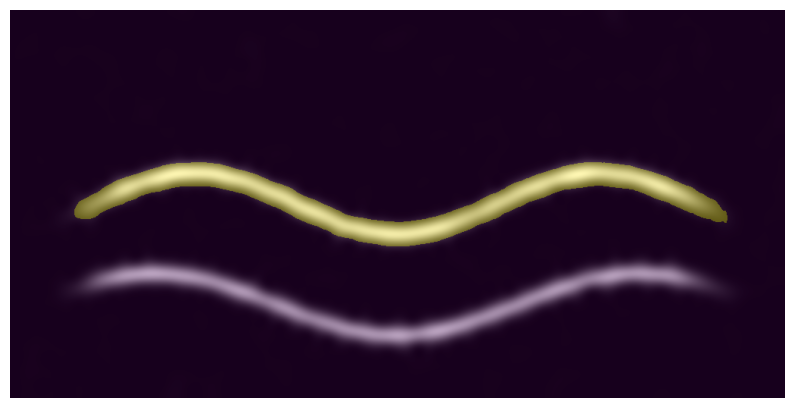

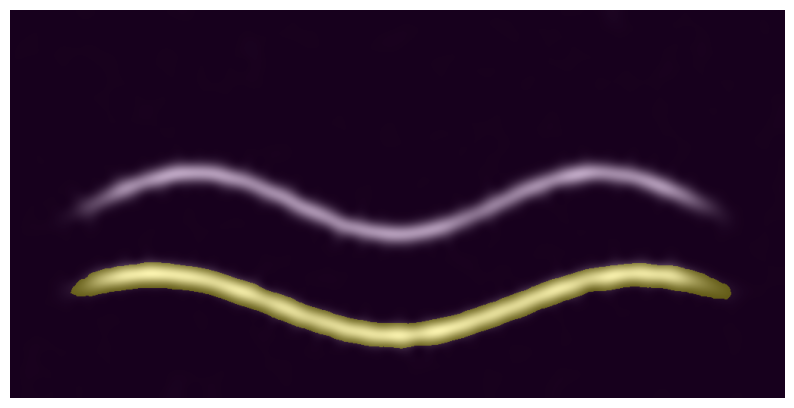

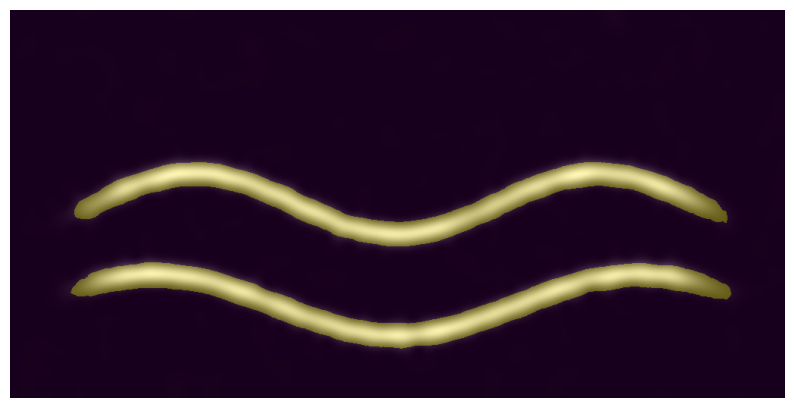

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.imshow(masks[0][0,:,:], alpha=0.35)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.imshow(masks[1][0,:,:], alpha=0.35)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.imshow(masks[2][0,:,:], alpha=0.35)
plt.axis('off')
plt.show()

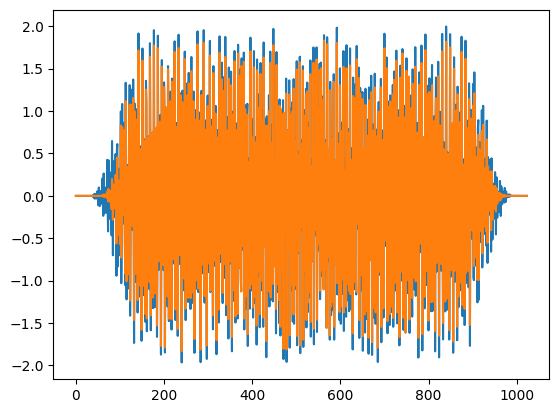

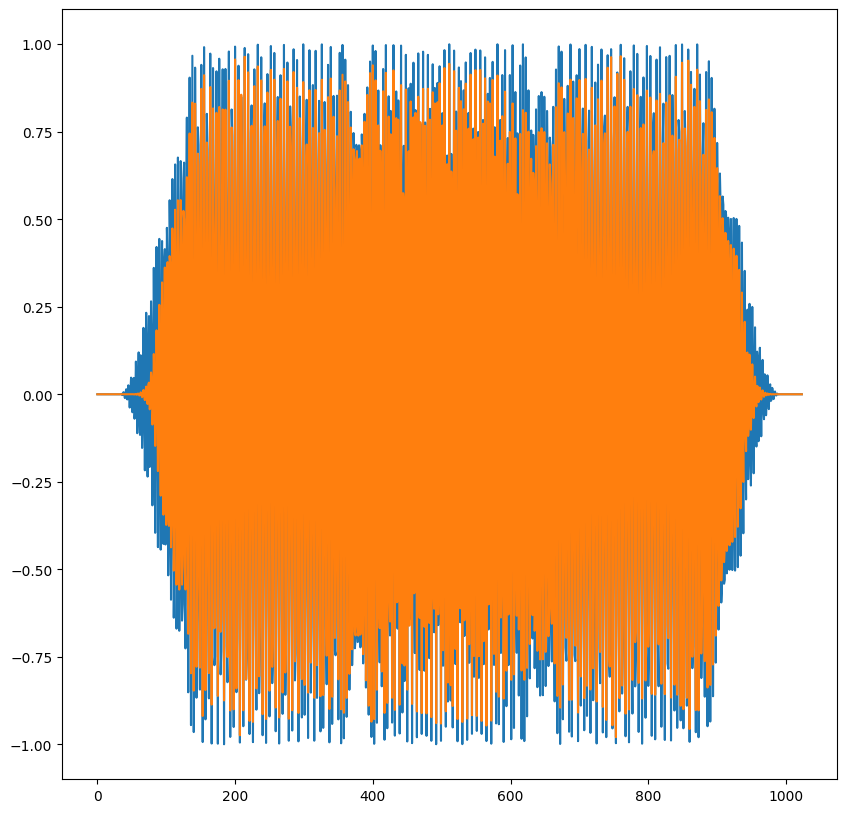

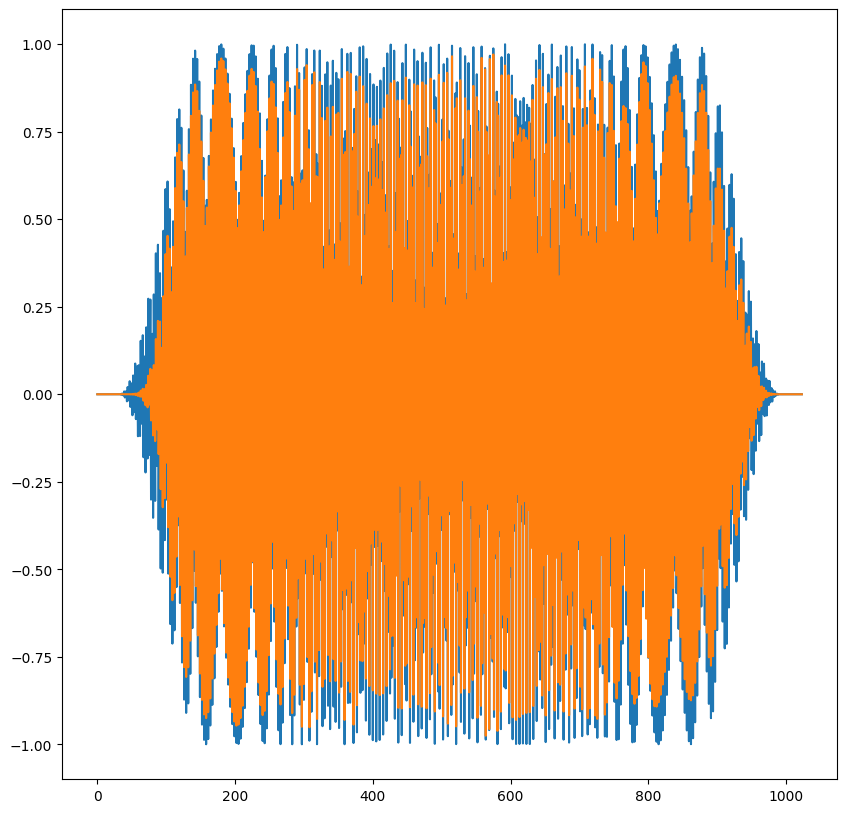

In [27]:
plt.plot(signal_noiseless)
plt.plot(xr[2])

plt.figure(figsize=(10,10))
plt.plot(x2)
plt.plot(xr[0])

plt.figure(figsize=(10,10))
plt.plot(x1)
plt.plot(xr[1])

In [33]:
r = np.corrcoef(x2, xr[0])[0, 1]

print(f"Coeficiente de correlación de Pearson: {r:.4f}")

Coeficiente de correlación de Pearson: 0.9965


In [50]:
SNRs = [snr for snr in range(0,25,5)]
SNRs

[0, 5, 10, 15, 20]

In [53]:
reps = 10
QRF = np.zeros((reps,len(SNRs)))

all_signals = [[None for _ in SNRs] for _ in range(reps)]
all_images  = [[None for _ in SNRs] for _ in range(reps)]
all_masks  = [[None for _ in SNRs] for _ in range(reps)]

def qrf(x,xhat):
  return 10*np.log10(np.sum(x**2)/np.sum((x-xhat)**2))

for j in range(reps):
    print(j)
    for i,snr in enumerate(SNRs):
        signal, noise = add_snr(signal_noiseless,snr)
        mascaras, imagenes, senal_reconst, _, _ = sam_filtering_final(signal, Nfft=N,)
        QRF[j,i] = qrf(signal_noiseless,senal_reconst[2])

0
snr_out:0.0
Estimated number of clusters: 3
Estimated number of noise points: 2
Cluster 0 tiene 15 puntos
Cluster 1 tiene 6 puntos
(1024, 1024)
(1, 513, 1024)
snr_out:5.0
Estimated number of clusters: 3
Estimated number of noise points: 2
Cluster 0 tiene 7 puntos
Cluster 1 tiene 8 puntos
(1024, 1024)
(1, 513, 1024)
snr_out:9.999999999999998
Estimated number of clusters: 3
Estimated number of noise points: 1
Cluster 0 tiene 9 puntos
Cluster 1 tiene 19 puntos
(1024, 1024)
(1, 513, 1024)
snr_out:15.0
Estimated number of clusters: 2
Estimated number of noise points: 0
Cluster 0 tiene 30 puntos
Cluster 1 tiene 21 puntos
(1024, 1024)
(1, 513, 1024)
snr_out:20.0
Estimated number of clusters: 2
Estimated number of noise points: 0
Cluster 0 tiene 39 puntos
Cluster 1 tiene 45 puntos
(1024, 1024)
(1, 513, 1024)
1
snr_out:0.0
Estimated number of clusters: 2
Estimated number of noise points: 11
Cluster 0 tiene 5 puntos
Cluster 1 tiene 11 puntos
(1024, 1024)
(1, 513, 1024)
snr_out:5.0
Estimated nu

IndexError: list index out of range